In [1]:
import pandas as pd
import numpy as np

# Load Data

In [2]:
gnss_trace_1 = pd.read_csv("/workspaces/ublox-gnss-eval-client/temp/gnns_log_2025_06_12/ss2/f9k_gnss_eval_192.168.10.137_50012_20250612_014323.csv")
gnss_trace_2 = pd.read_csv("/workspaces/ublox-gnss-eval-client/temp/gnns_log_2025_06_12/ss2/f9r_gnss_eval_192.168.10.137_50011_20250612_014328.csv")

# Preprocessing

In [3]:
# exclude colums 'HPE(m)','NorthingError(m)', 'EastingError(m)', 'MessageRate(Hz)'
gnss_trace_1 = gnss_trace_1.drop(columns=['HPE(m)', 'NorthingError(m)', 'EastingError(m)', 'MessageRate(Hz)'])
gnss_trace_2 = gnss_trace_2.drop(columns=['HPE(m)', 'NorthingError(m)', 'EastingError(m)', 'MessageRate(Hz)'])

In [4]:
SELECTED_FIXTYPE = [
    'dead-reckoning',
    'fixed-rtk',
    # 'extrapolated'
]

filtered_trace_1 = gnss_trace_1[gnss_trace_1['FixType'].isin(SELECTED_FIXTYPE)]
filtered_trace_2 = gnss_trace_2[gnss_trace_2['FixType'].isin(SELECTED_FIXTYPE)]

In [5]:
# # test sync time

# df_a_proc = filtered_trace_1.copy()
# df_b_proc = filtered_trace_2.copy()
# time_col='TimestampKST'

# for df in [df_a_proc, df_b_proc]:
#     df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
#     df.set_index(time_col, inplace=True)
    
#     df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
#     df = df[df.index.notna()]
    
#     df.sort_index(inplace=True)
    
# if df_a_proc.empty or df_b_proc.empty:
#     print("Warning: One or both datasets are empty after cleaning.")
    

In [6]:
# start_time_a = df_a_proc.index.min()
# end_time_a = df_a_proc.index.max()

# start_time_b = df_b_proc.index.min()
# end_time_b = df_b_proc.index.max()
# common_start_time = max(start_time_a, start_time_b)
# common_end_time = min(end_time_a, end_time_b)
# if common_start_time >= common_end_time:
#     print("Warning: No overlapping time window found.")

# # --- 3. Trim to Common Window ---
# df_a_trimmed = df_a_proc.loc[common_start_time:common_end_time]
# df_b_trimmed = df_b_proc.loc[common_start_time:common_end_time]

# synced_a = df_a_trimmed
# # --- 4. Interpolate and Create synced_b ---
# combined_index = synced_a.index.union(df_b_trimmed.index)
# df_b_reindexed = df_b_trimmed.reindex(combined_index)

In [7]:
import pandas as pd
import numpy as np

def sync_gnss(df_a, df_b, time_col='TimestampKST'):
    """
    Synchronizes two GNSS DataFrames within their common time window and sets
    the FixType of BOTH output DataFrames to 'synced'.

    Args:
        df_a (pd.DataFrame): The reference DataFrame.
        df_b (pd.DataFrame): The DataFrame to be realigned and interpolated.
        time_col (str): The name of the column containing the timestamps.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame] or tuple[None, None]:
            A tuple containing two synchronized DataFrames (synced_a, synced_b).
            Both will have their 'FixType' column set to 'synced'.
            Returns (None, None) if there is no overlapping time period.
    """
    # --- 1. Prepare DataFrames ---
    df_a_proc = df_a.copy()
    df_b_proc = df_b.copy()

    for df in [df_a_proc, df_b_proc]:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.set_index(time_col, inplace=True)
        
        df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
        df = df[df.index.notna()]
        
        df.sort_index(inplace=True)

    if df_a_proc.empty or df_b_proc.empty:
        print("Warning: One or both datasets are empty after cleaning.")
        return None, None

    # --- 2. Determine Common Time Window ---
    start_time_a = df_a_proc.index.min()
    end_time_a = df_a_proc.index.max()
    
    start_time_b = df_b_proc.index.min()
    end_time_b = df_b_proc.index.max()

    common_start_time = max(start_time_a, start_time_b)
    common_end_time = min(end_time_a, end_time_b)

    if common_start_time >= common_end_time:
        print("Warning: No overlapping time window found.")
        return None, None

    # --- 3. Trim to Common Window ---
    df_a_trimmed = df_a_proc.loc[common_start_time:common_end_time]
    df_b_trimmed = df_b_proc.loc[common_start_time:common_end_time]
    
    synced_a = df_a_trimmed

    # --- 4. Interpolate and Create synced_b ---
    combined_index = synced_a.index.union(df_b_trimmed.index)
    df_b_reindexed = df_b_trimmed.reindex(combined_index)

    numeric_cols = df_b_reindexed.select_dtypes(include=np.number).columns.tolist()
    df_b_reindexed[numeric_cols] = df_b_reindexed[numeric_cols].interpolate(method='time')

    synced_b = df_b_reindexed.reindex(synced_a.index)

    # --- MODIFICATION: Set FixType for BOTH synchronized DataFrames ---
    # This standardizes the output to show both are part of the synced set.
    for df in [synced_a, synced_b]:
        if 'FixType' in df.columns:
            df.loc[:, 'FixType'] = 'synced'

    return synced_a, synced_b

In [8]:
synced_trace_1, synced_trace_2 = sync_gnss(
    filtered_trace_1, 
    filtered_trace_2,
)

start_time_compare = synced_trace_1.index.min() + pd.Timedelta(minutes=1)
end_time_compare = synced_trace_1.index.min()  + pd.Timedelta(minutes=2)

synced_trace_1 = synced_trace_1.loc[start_time_compare:end_time_compare]
synced_trace_2 = synced_trace_2.loc[start_time_compare:end_time_compare]

In [9]:
len(synced_trace_1), len(synced_trace_2)

(43, 43)

In [10]:
# synced_trace_1.to_csv("f9k_sync1.csv", index=True)
# synced_trace_2.to_csv("f9r_sync1.csv", index=True)

In [11]:
# def haversine_distance(lat1, lon1, lat2, lon2):
#     """
#     Calculate the great-circle distance between two points on the earth (specified in decimal degrees).
#     Returns the distance in meters.
#     """
#     R = 6371000  # Radius of Earth in meters
    
#     lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])

#     dlon = lon2_rad - lon1_rad
#     dlat = lat2_rad - lat1_rad

#     a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#     distance = R * c

#     return distance
from haversine import haversine

def compare_gnss_sequences(synced_a, synced_b, antenna_offset_m=0.0):
    """
    Compares two synchronized GNSS DataFrames using the Haversine distance
    and accounts for a known antenna offset.

    Args:
        synced_a (pd.DataFrame): The first synchronized DataFrame (from device A).
        synced_b (pd.DataFrame): The second synchronized DataFrame (from device B).
        antenna_offset_m (float): The known physical distance (in meters) between the antennas.

    Returns:
        tuple[pd.DataFrame, dict]:
            - A single DataFrame containing the data for both devices and the
              calculated position difference for each timestamp.
            - A dictionary containing raw and offset-corrected summary statistics.
    """
    if synced_a is None or synced_b is None:
        print("Error: Input DataFrames cannot be None.")
        return None, None
        
    # --- 1. Combine DataFrames for easy comparison ---
    df_a_renamed = synced_a.rename(columns={'Latitude': 'Latitude_A', 'Longitude': 'Longitude_A', 'FixType': 'FixType_A'})
    df_b_renamed = synced_b.rename(columns={'Latitude': 'Latitude_B', 'Longitude': 'Longitude_B', 'FixType': 'FixType_B'})
    
    comparison_df = df_a_renamed.join(df_b_renamed)

    # --- 2. Calculate the Haversine Distance for each point ---
    comparison_df['Position_Difference_m'] = comparison_df.apply(
        lambda row: haversine(
            (row['Latitude_A'], row['Longitude_A']),
            (row['Latitude_B'], row['Longitude_B']),
            unit='m'
        ),
        axis=1
    )
    # comparison_df['Position_Difference_m'] = haversine_distance(
    #     comparison_df['Latitude_A'],
    #     comparison_df['Longitude_A'],
    #     comparison_df['Latitude_B'],
    #     comparison_df['Longitude_B']
    # )

    # --- 3. Calculate Summary Statistics for Similarity ---
    diff_series = comparison_df['Position_Difference_m']
    mean_diff = diff_series.mean()
    std_diff = diff_series.std()
    rms_diff = np.sqrt((diff_series ** 2).mean())

    # --- MODIFICATION: Calculate the corrected mean ---
    # This shows the average error beyond the expected physical separation.
    corrected_mean_diff = mean_diff - antenna_offset_m

    # Update stats dictionary to include raw and corrected values
    stats = {
        'Antenna Offset': f"{antenna_offset_m:.4f} meters",
        '--- Raw Statistics ---': '',
        'Mean Difference': f"{mean_diff:.4f} meters",
        'Standard Deviation': f"{std_diff:.4f} meters",
        'RMS Difference': f"{rms_diff:.4f} meters",
        '--- Offset-Corrected Statistics ---': '',
        'Corrected Mean Difference': f"{corrected_mean_diff:.4f} meters"
    }

    return comparison_df, stats

In [12]:
comparison_df, stats = compare_gnss_sequences(
    synced_trace_1,
    synced_trace_2,
    antenna_offset_m=0.00)
print("Comparison DataFrame:")
print(comparison_df.head())
print("\nStatistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

Comparison DataFrame:
                                  Latitude_A  Longitude_A FixType_A  \
TimestampKST                                                          
2025-06-12 01:44:30.339262+09:00   36.097459   128.391818    synced   
2025-06-12 01:44:31.359283+09:00   36.097455   128.391775    synced   
2025-06-12 01:44:32.363536+09:00   36.097452   128.391726    synced   
2025-06-12 01:44:33.361497+09:00   36.097450   128.391667    synced   
2025-06-12 01:44:34.652162+09:00   36.097448   128.391601    synced   

                                  Latitude_B  Longitude_B FixType_B  \
TimestampKST                                                          
2025-06-12 01:44:30.339262+09:00   36.097459   128.391825    synced   
2025-06-12 01:44:31.359283+09:00   36.097455   128.391781    synced   
2025-06-12 01:44:32.363536+09:00   36.097452   128.391733    synced   
2025-06-12 01:44:33.361497+09:00   36.097450   128.391672    synced   
2025-06-12 01:44:34.652162+09:00   36.097448   128.391

<Axes: title={'center': 'Position Difference (m)'}, xlabel='TimestampKST'>

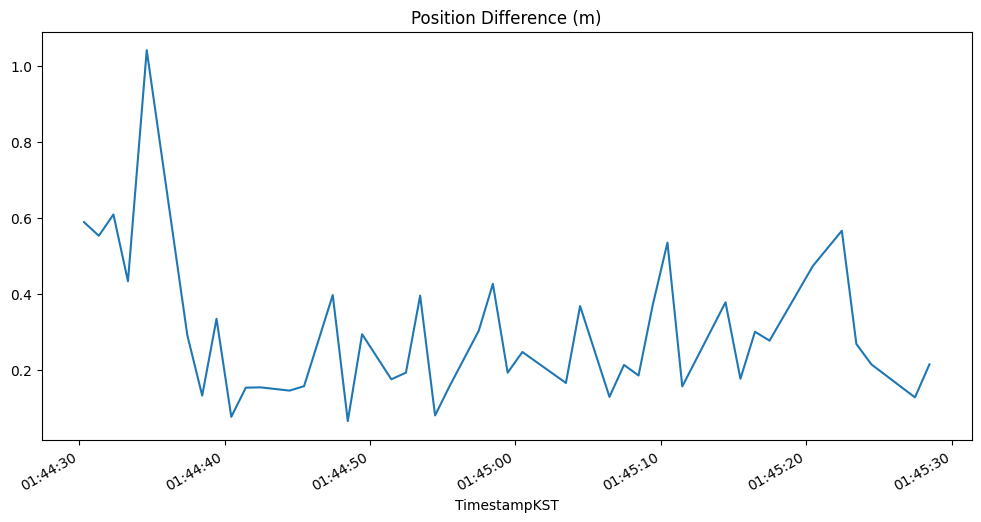

In [13]:
comparison_df['Position_Difference_m'].plot(title='Position Difference (m)', figsize=(12, 6))